In [24]:
import collections
import itertools
import json
import os
import re
import glob
import operator

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

In [10]:
def compute_accuracy(rows):
    levels = ['easy', 'medium', 'hard', 'extra', 'all']
    total = collections.defaultdict(int)
    exact = collections.defaultdict(int)
    for row in rows:
        exact[row['hardness']] += row['exact']
        exact['all'] += row['exact']
        total[row['hardness']] += 1
        total['all'] += 1
    
    result = {hardness: exact[hardness] / total[hardness]
              for hardness in levels}
    result = {**result, **{'{} count'.format(hardness): total[hardness] for hardness in levels}}
    return result

In [27]:
accuracy_per_run = collections.defaultdict(dict)
rows = []
for d in sorted(glob.glob('../logdirs/20190428-random/*')):
    exp_name = os.path.basename(d)
    fixed, att = re.match('fixed=([^,]+),att=(\d+)', exp_name).groups()

    eval_paths = glob.glob(os.path.join(d, 'eval-val-step*-bs1.jsonl'))
    all_scores = []
    best = (0, 0)
    for eval_path in eval_paths:
        step = int(re.search('step(\d+)', eval_path).group(1))
        scores = json.load(open(eval_path))
        first_half_exact = compute_accuracy(scores['per_item'][:517])
        second_half_exact = compute_accuracy(scores['per_item'][517:])
        all_scores.append((step, scores['total_scores']['all']['exact'], first_half_exact['all'], second_half_exact['all']))
    
    all_scores.sort(key=operator.itemgetter(0))
    sorted_scores = sorted(all_scores, reverse=True, key=operator.itemgetter(1))
    rows.append((fixed, att, len(eval_paths)) + (sorted_scores[0] if sorted_scores else (-1, -1, -1, -1)))
    accuracy_per_run[exp_name] = {
        'x': [s[0] for s in all_scores],
        'all': [s[1] for s in all_scores],
        '1/2': [s[2] for s in all_scores],
        '2/2': [s[3] for s in all_scores],
    }
    print(d)
    
df = pd.DataFrame(rows, columns=('fixed', 'att', 'num steps eval', 'step', 'acc', '1/2 acc', '2/2 acc'))

../logdirs/20190428-random/fixed=data+model,att=0
../logdirs/20190428-random/fixed=data+model,att=1
../logdirs/20190428-random/fixed=data+model,att=2
../logdirs/20190428-random/fixed=data+model,att=3
../logdirs/20190428-random/fixed=init,att=0
../logdirs/20190428-random/fixed=init,att=1
../logdirs/20190428-random/fixed=init,att=2
../logdirs/20190428-random/fixed=init,att=3


In [14]:
df

,fixed,att,num steps eval,step,acc,1/2 acc,2/2 acc
0,data+model,0,40,37100,0.369439,0.377176,0.361702
1,data+model,1,40,40000,0.382012,0.367505,0.396518
2,data+model,2,40,37100,0.373308,0.367505,0.379110
3,data+model,3,40,37100,0.381044,0.396518,0.365571
4,init,0,40,38100,0.376209,0.381044,0.371373
5,init,1,40,33100,0.362669,0.381044,0.344294
6,init,2,40,40000,0.367505,0.384913,0.350097
7,init,3,40,40000,0.367505,0.384913,0.350097


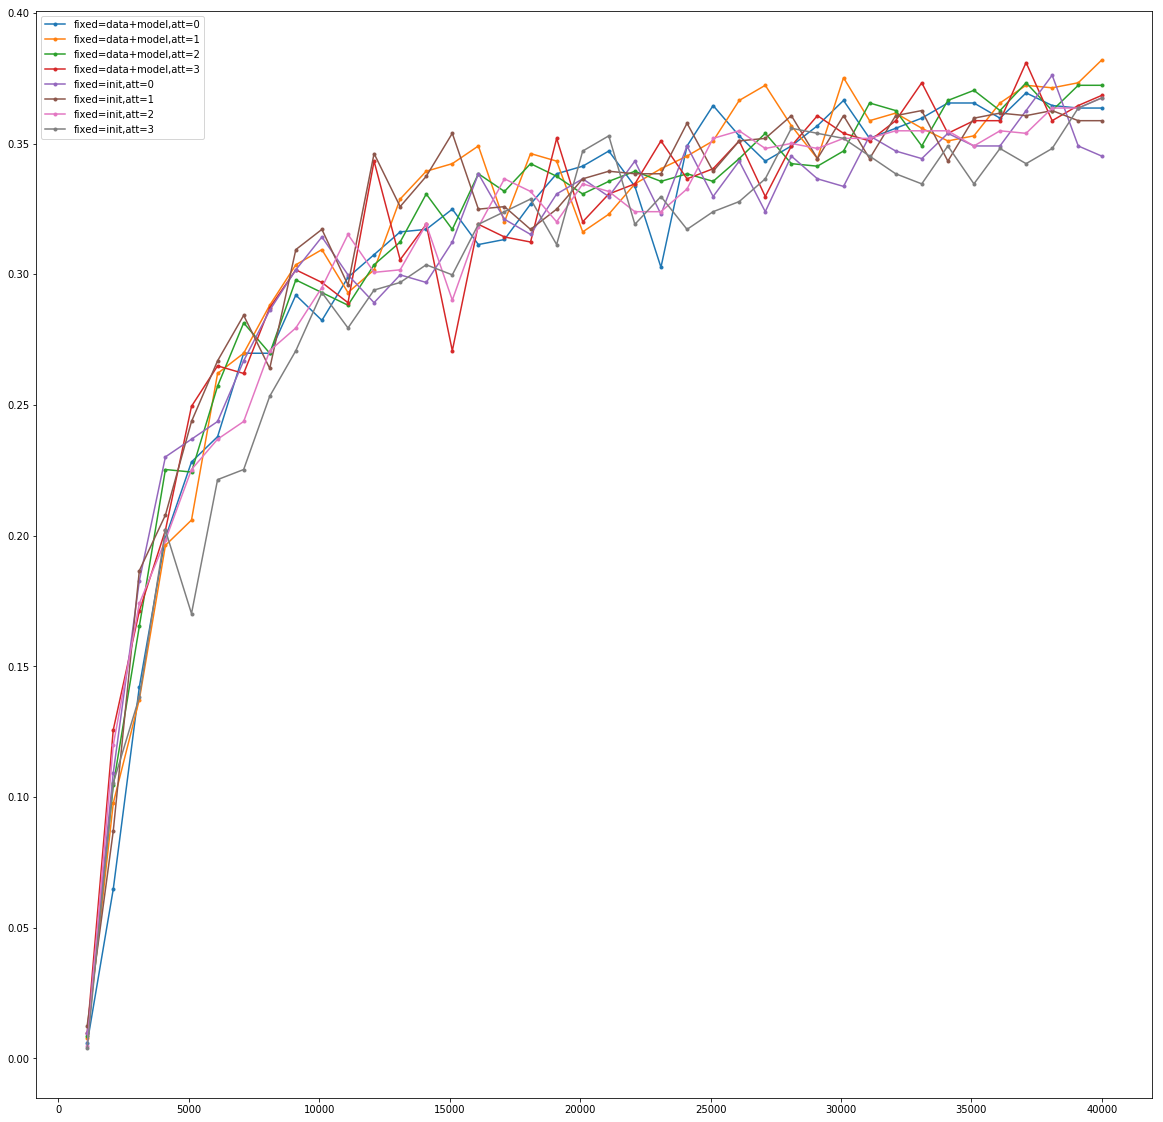

In [15]:
# See how accuracy varies over time
for k, v in sorted(accuracy_per_run.items()):
    plt.plot(v['x'], v['all'], marker='.', label=k)
plt.legend()

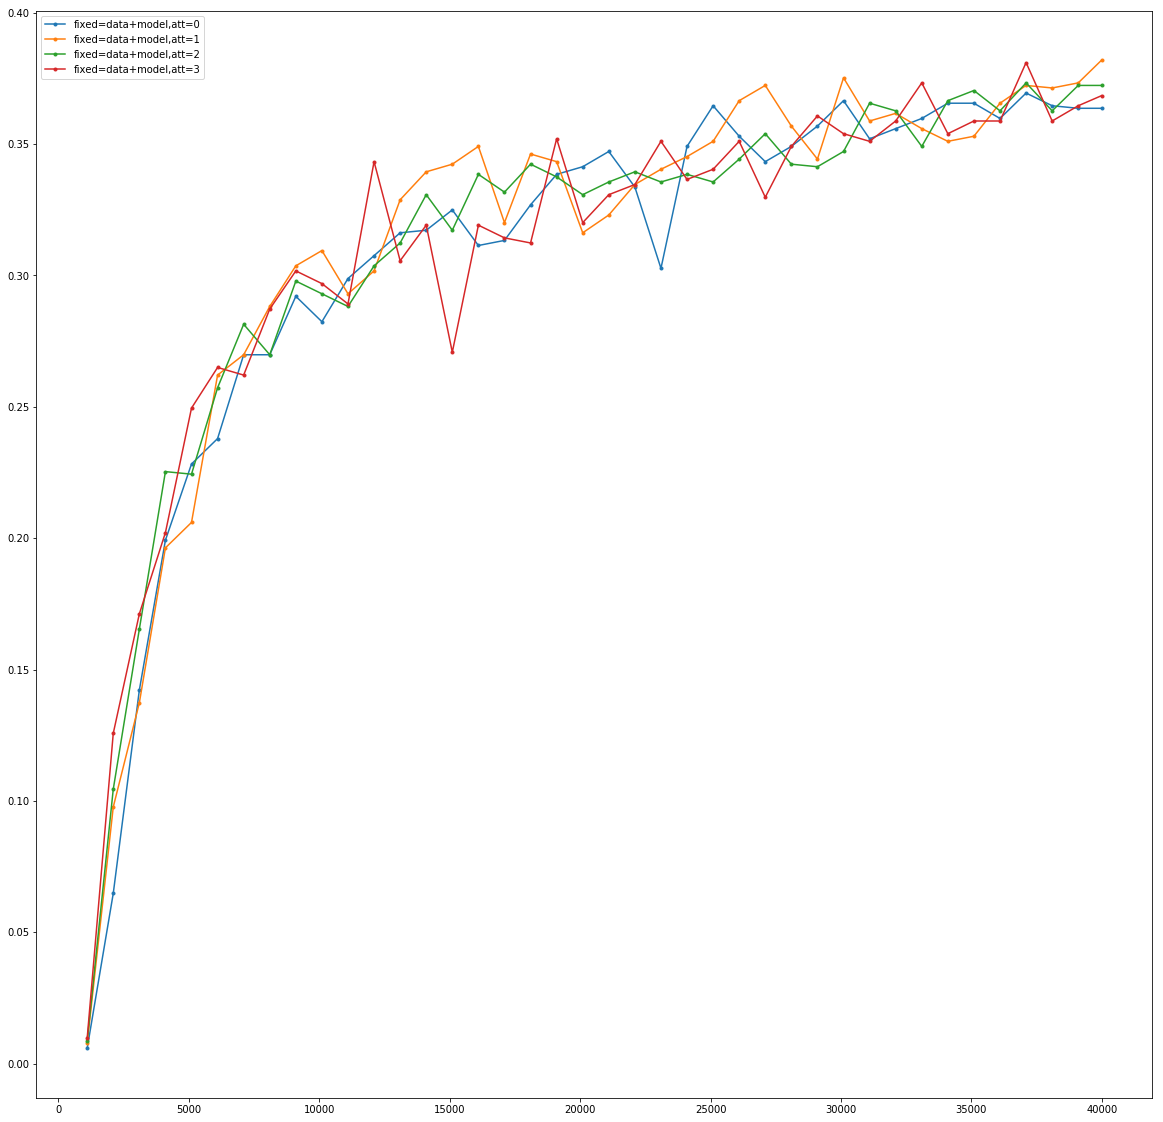

In [16]:
# See how accuracy varies over time
for k, v in sorted(accuracy_per_run.items())[:4]:
    plt.plot(v['x'], v['all'], marker='.', label=k)
plt.legend()

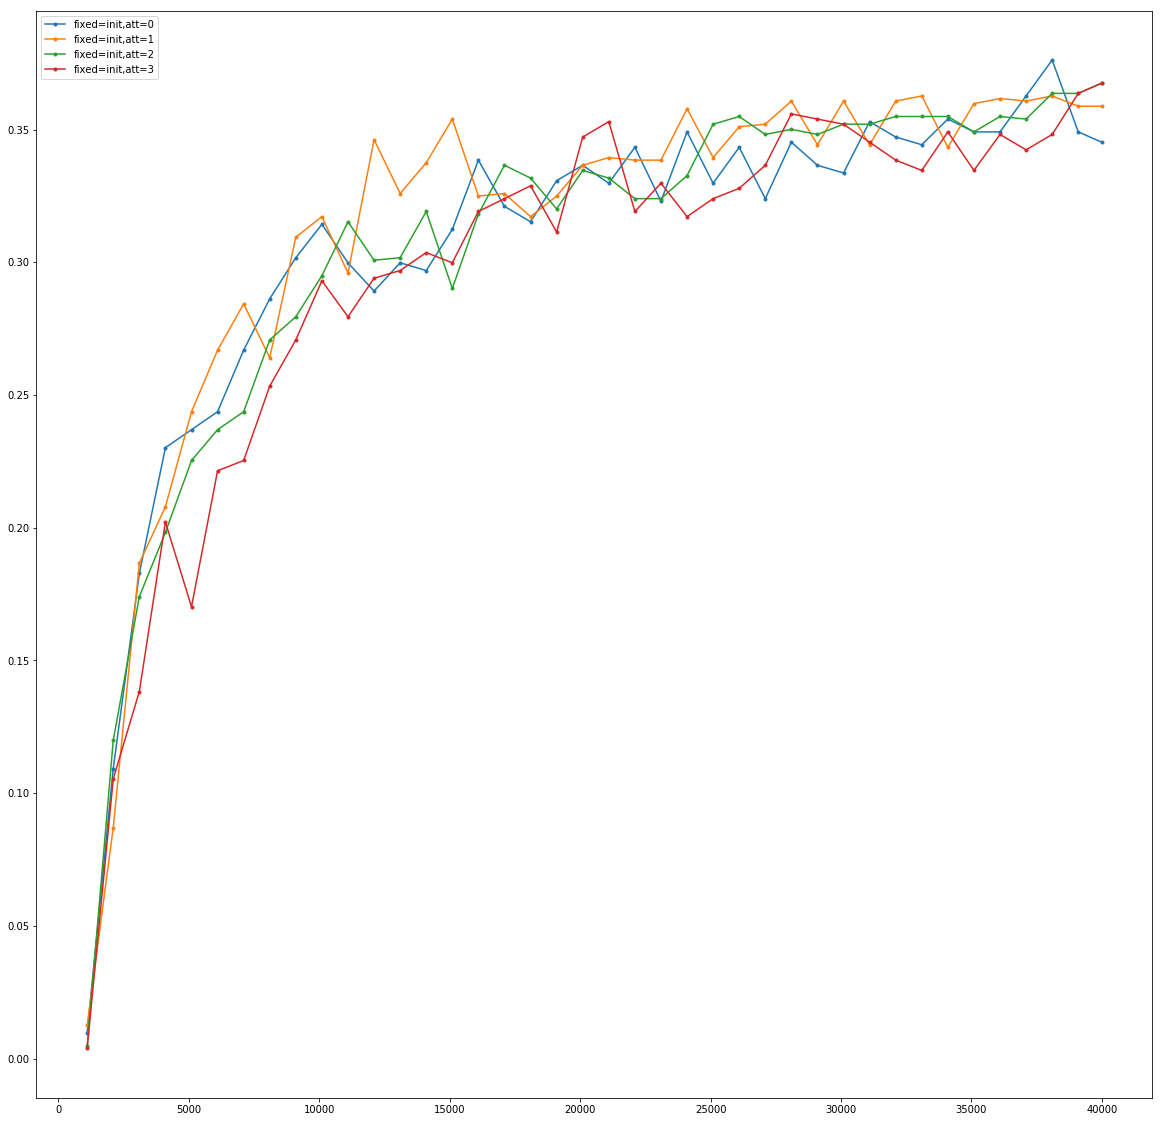

In [17]:
# See how accuracy varies over time
for k, v in sorted(accuracy_per_run.items())[4:]:
    plt.plot(v['x'], v['all'], marker='.', label=k)
plt.legend()

In [20]:
dev = json.load(open('../data/spider-20190205/dev.json'))
def compare(data, left, right):
    both_exact = []
    left_exact = []
    right_exact = []
    neither_exact = []
    for i, (data_item, left_item, right_item) in enumerate(zip(data, left['per_item'], right['per_item'])):
        result = {
            'i': i,
            'db_id': data_item['db_id'],
            'question': data_item['question'],
            'gold': data_item['query'],
            'left': left_item['predicted'],
            'right': right_item['predicted'],
        }
        
        if left_item['exact'] and right_item['exact']:
            both_exact.append(result)
        elif left_item['exact']:
            left_exact.append(result)
        elif right_item['exact']:
            right_exact.append(result)
        else:
            neither_exact.append(result)
    return both_exact, left_exact, right_exact, neither_exact        

In [22]:
both_exact, left_exact, right_exact, neither_exact = compare(
    dev,
    json.load(open('../logdirs/20190428-random/fixed=init,att=0/eval-val-step38100-bs1.jsonl')),
    json.load(open('../logdirs/20190428-random/fixed=init,att=1/eval-val-step33100-bs1.jsonl')))
len(both_exact)/len(dev), len(left_exact)/len(dev), len(right_exact)/len(dev)

(0.27949709864603484, 0.09671179883945841, 0.08317214700193423)

In [23]:
both_exact, left_exact, right_exact, neither_exact = compare(
    dev,
    json.load(open('../logdirs/20190428-random/fixed=data+model,att=0/eval-val-step37100-bs1.jsonl')),
    json.load(open('../logdirs/20190428-random/fixed=data+model,att=1/eval-val-step40000-bs1.jsonl')))
len(both_exact)/len(dev), len(left_exact)/len(dev), len(right_exact)/len(dev)

(0.27852998065764023, 0.09090909090909091, 0.10348162475822051)

In [25]:
accuracy_per_run = collections.defaultdict(dict)
rows = []
for d in sorted(glob.glob('../logdirs/20190428-stability/*')):
    exp_name = os.path.basename(d)
    batch_size, lr, end_lr, att = re.match('bs=([^,]+),lr=([^,]+),end_lr=([^,]+),att=([^,]+)', exp_name).groups()

    eval_paths = glob.glob(os.path.join(d, 'eval-val-step*-bs1.jsonl'))
    all_scores = []
    best = (0, 0)
    for eval_path in eval_paths:
        step = int(re.search('step(\d+)', eval_path).group(1))
        scores = json.load(open(eval_path))
        first_half_exact = compute_accuracy(scores['per_item'][:517])
        second_half_exact = compute_accuracy(scores['per_item'][517:])
        all_scores.append((step, scores['total_scores']['all']['exact'], first_half_exact['all'], second_half_exact['all']))
    
    all_scores.sort(key=operator.itemgetter(0))
    sorted_scores = sorted(all_scores, reverse=True, key=operator.itemgetter(1))
    rows.append((batch_size, lr, end_lr, att, len(eval_paths)) + (sorted_scores[0] if sorted_scores else (-1, -1, -1, -1)))
    accuracy_per_run[exp_name] = {
        'x': [s[0] for s in all_scores],
        'all': [s[1] for s in all_scores],
        '1/2': [s[2] for s in all_scores],
        '2/2': [s[3] for s in all_scores],
    }
    print(d)
    
df = pd.DataFrame(rows, columns=('batch_size', 'lr', 'end_lr', 'att', 'num steps eval', 'step', 'acc', '1/2 acc', '2/2 acc'))

../logdirs/20190428-stability/bs=10,lr=1.0e-03,end_lr=2.5e-04,att=0
../logdirs/20190428-stability/bs=10,lr=1.0e-03,end_lr=5.0e-04,att=0
../logdirs/20190428-stability/bs=10,lr=2.5e-04,end_lr=0e0,att=0
../logdirs/20190428-stability/bs=10,lr=5.0e-04,end_lr=0e0,att=0
../logdirs/20190428-stability/bs=100,lr=1.0e-03,end_lr=0e0,att=0
../logdirs/20190428-stability/bs=100,lr=1.0e-03,end_lr=0e0,att=1
../logdirs/20190428-stability/bs=100,lr=1.0e-03,end_lr=0e0,att=2
../logdirs/20190428-stability/bs=50,lr=1.0e-03,end_lr=0e0,att=0
../logdirs/20190428-stability/bs=50,lr=1.0e-03,end_lr=0e0,att=1
../logdirs/20190428-stability/bs=50,lr=1.0e-03,end_lr=0e0,att=2


In [26]:
df

,batch_size,lr,end_lr,att,num steps eval,step,acc,1/2 acc,2/2 acc
0,10,1.0e-03,2.5e-04,0,40,39100,0.381044,0.400387,0.361702
1,10,1.0e-03,5.0e-04,0,40,25100,0.377176,0.406190,0.348162
2,10,2.5e-04,0e0,0,40,40000,0.395551,0.396518,0.394584
3,10,5.0e-04,0e0,0,40,26100,0.378143,0.377176,0.379110
4,100,1.0e-03,0e0,0,40,31100,0.423598,0.429400,0.417795
5,100,1.0e-03,0e0,1,22,14100,0.407157,0.415861,0.398453
6,100,1.0e-03,0e0,2,21,20100,0.434236,0.431335,0.437137
7,50,1.0e-03,0e0,0,40,40000,0.424565,0.437137,0.411992
8,50,1.0e-03,0e0,1,40,38100,0.411992,0.423598,0.400387
9,50,1.0e-03,0e0,2,40,40000,0.429400,0.439072,0.419729


In [5]:
r = json.load(open('../logdirs/20190428-stability/bs=50,lr=1.0e-03,end_lr=0e0,att=2/eval-val-step21100-bs1.jsonl'))

In [6]:
scores = [r['total_scores'][sec]['exact'] for sec in ('easy', 'medium', 'hard', 'extra', 'all')]

In [7]:
scores

[0.588,
 0.4159090909090909,
 0.42528735632183906,
 0.21764705882352942,
 0.42649903288201163]

In [18]:
# Vocabulary analysis
vocab = json.load(open('../data/spider-20190205/nl2code-0214-nofrom-notinc/enc_vocab.json'))
vocab_count = collections.OrderedDict((word, 0) for word in vocab)
for line in open('../data/spider-20190205/nl2code-0214-nofrom-notinc/enc/train.jsonl'):
    line = json.loads(line)
    for token in itertools.chain(line['question'], *line['tables'], *line['columns']):
        if token in vocab_count:
            vocab_count[token] += 1
        else:
            vocab_count['<UNK>'] += 1
vocab_by_occurrence = sorted(vocab_count.items(), key=operator.itemgetter(1), reverse=True)

In [30]:
dev = [json.loads(line) for line in open('../data/spider-20190205/nl2code-0214-nofrom-notinc/enc/val.jsonl')]
results = json.load(open('../logdirs/20190521-ablations/glove=false,upd_type=full,num_layers=4,att=0/eval-val-step11100-bs1.jsonl'))
best_results = json.load(open('../logdirs/20190428-stability/bs=50,lr=1.0e-03,end_lr=0e0,att=2/eval-val-step40000-bs1.jsonl'))

In [20]:
dev_unk_counts = []
for line in open('../data/spider-20190205/nl2code-0214-nofrom-notinc/enc/val.jsonl'):
    line = json.loads(line)
    info = {'question unks': 0, 'question count': 0,
            'tables unks': 0, 'tables count': 0,
            'columns unks': 0, 'columns count': 0}
    
    for token in line['question']:
        if token not in vocab_count:
            info['question unks'] += 1
        info['question count'] += 1
    for s in ('tables', 'columns'):
        for token in itertools.chain(*line[s]):
            if token not in vocab_count:
                info['{} unks'.format(s)] += 1
            info['{} count'.format(s)] += 1
    dev_unk_counts.append(info)

In [21]:
dev_no_schema_unk_idx = [i for i, c in enumerate(dev_unk_counts) if c['columns unks'] == 0 and c['tables unks'] == 0]
dev_no_question_unk_idx = [i for i, c in enumerate(dev_unk_counts) if c['question unks'] == 0]

In [23]:
compute_accuracy(results['per_item'][i] for i in dev_no_schema_unk_idx)

{'all': 0.4444444444444444,
 'all count': 18,
 'easy': 0.6666666666666666,
 'easy count': 3,
 'extra': 0.5,
 'extra count': 4,
 'hard': 0.3333333333333333,
 'hard count': 3,
 'medium': 0.375,
 'medium count': 8}

In [22]:
compute_accuracy(results['per_item'][i] for i in dev_no_question_unk_idx)

{'all': 0.401673640167364,
 'all count': 239,
 'easy': 0.4838709677419355,
 'easy count': 62,
 'extra': 0.06060606060606061,
 'extra count': 33,
 'hard': 0.4857142857142857,
 'hard count': 35,
 'medium': 0.43119266055045874,
 'medium count': 109}

In [31]:
compute_accuracy(best_results['per_item'][i] for i in dev_no_question_unk_idx)

{'all': 0.502092050209205,
 'all count': 239,
 'easy': 0.5483870967741935,
 'easy count': 62,
 'extra': 0.15151515151515152,
 'extra count': 33,
 'hard': 0.5428571428571428,
 'hard count': 35,
 'medium': 0.5688073394495413,
 'medium count': 109}

In [29]:
(62/239, 109/239, 35/239, 33/239)

(0.2594142259414226,
 0.4560669456066946,
 0.14644351464435146,
 0.13807531380753138)

In [27]:
compute_accuracy(results['per_item'])

{'all': 0.2775628626692456,
 'all count': 1034,
 'easy': 0.408,
 'easy count': 250,
 'extra': 0.058823529411764705,
 'extra count': 170,
 'hard': 0.27011494252873564,
 'hard count': 174,
 'medium': 0.2909090909090909,
 'medium count': 440}

In [28]:
(250/1034, 440/1034, 174/1034, 170/1034)

(0.24177949709864605,
 0.425531914893617,
 0.16827852998065765,
 0.1644100580270793)

In [15]:
# beam size 15
!CUDA_VISIBLE_DEVICES= python infer.py \
    --config configs/spider-20190205/nl2code-0428-stability.jsonnet \
    --logdir logdirs/20190428-stability \
    --config-args "{bs: 50, lr: 1e-3, end_lr: 0e0, att: 2}" \
    --output __LOGDIR__/infer-val-40000-bs15.jsonl --step 40000 --section val --beam-size 15

python: can't open file 'infer.py': [Errno 2] No such file or directory


In [17]:
[json.load(open('../logdirs/20190428-stability/bs=50,lr=1.0e-03,end_lr=0e0,att=2/eval-val-40000-bs15.jsonl'))['total_scores'][sec]['exact'] for sec in ('easy', 'medium', 'hard', 'extra', 'all')]

[0.572,
 0.44772727272727275,
 0.39655172413793105,
 0.21176470588235294,
 0.43036750483558994]

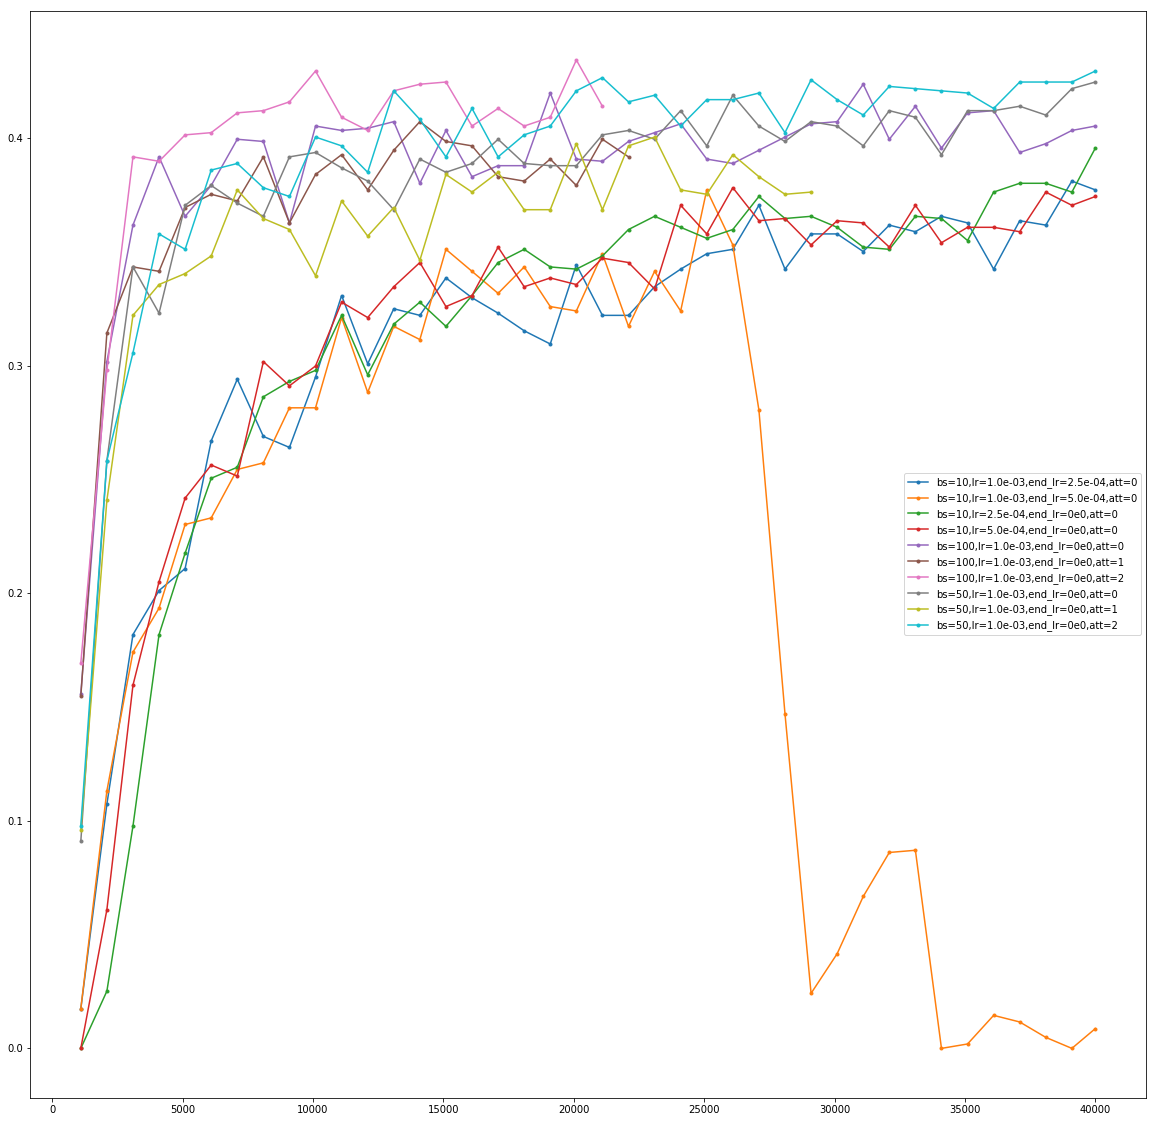

In [14]:
# See how accuracy varies over time
for k, v in sorted(accuracy_per_run.items()):
    plt.plot(v['x'], v['all'], marker='.', label=k)
plt.legend()

In [26]:
both_exact, left_exact, right_exact, neither_exact = compare(
    dev,
    json.load(open('../logdirs/20190428-stability/bs=100,lr=1.0e-03,end_lr=0e0,att=0/eval-val-step10100-bs1.jsonl')),
    json.load(open('../logdirs/20190428-stability/bs=50,lr=1.0e-03,end_lr=0e0,att=0/eval-val-step21100-bs1.jsonl')))
len(both_exact)/len(dev), len(left_exact)/len(dev), len(right_exact)/len(dev)

(0.3181818181818182, 0.08704061895551257, 0.08317214700193423)